# Image-Based Airbnb Pricing Algorithm
- Created a deep learning alogrithm to predict the price of an Airbnb listing only from a picture from the listing
- used two types of CNN's models
    1. a custom CNN 
    2. InceptionV3 that was pre-trained on the image_net dataset    
- Data: downloaded a csv with Airbnb data from http://insideairbnb.com/get-the-data.html 
    - only used data from NY


## Understanding / Cleaning the data

In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import *


tf.VERSION

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.9.0'

In [2]:
# download the data and make the price column into floats instead of strings
Airbnb_data = pd.read_csv('listings.csv')
Airbnb_data['price'] = Airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (61,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# veiw the data
Airbnb_data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2515,https://www.airbnb.com/rooms/2515,20181206022948,2018-12-06,Stay at Chez Chic budget room #1,Step into our artistic spacious apartment and ...,-PLEASE BOOK DIRECTLY. NO NEED TO SEND A REQUE...,Step into our artistic spacious apartment and ...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,1.42
1,21456,https://www.airbnb.com/rooms/21456,20181206022948,2018-12-06,Light-filled classic Central Park,"An adorable, classic, clean, light-filled one-...","An adorable, classic, clean, light-filled one-...","An adorable, classic, clean, light-filled one-...",none,"Diverse. Great coffee shops and restaurants, n...",...,f,NaN,NaN,f,f,moderate,t,t,1,0.72
2,2539,https://www.airbnb.com/rooms/2539,20181206022948,2018-12-06,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,NaN,NaN,f,f,moderate,f,f,8,0.25
3,2595,https://www.airbnb.com/rooms/2595,20181206022948,2018-12-06,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,2,0.37
4,21644,https://www.airbnb.com/rooms/21644,20181206022948,2018-12-06,"Upper Manhattan, New York",A great space in a beautiful neighborhood- min...,Nice room in a spacious pre-war apartment in u...,A great space in a beautiful neighborhood- min...,none,I love that the neighborhood is safe to walk a...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.51


In [4]:
Airbnb_data.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,4.905600e+04,4.905600e+04,0.0,0.0,0.0,4.905600e+04,0.0,49049.000000,49049.000000,49056.000000,...,49056.000000,37746.000000,37703.000000,37720.000000,37680.000000,37707.000000,37674.000000,37675.000000,49056.000000,38761.000000
mean,1.632664e+07,2.018121e+13,NaN,NaN,NaN,5.454690e+07,NaN,11.960835,11.960835,40.729711,...,22.156107,93.882027,9.610694,9.272508,9.747903,9.760204,9.509980,9.382747,4.767694,1.436953
std,9.219480e+06,7.902424e+00,NaN,NaN,NaN,6.338292e+07,NaN,92.219395,92.219395,0.053469,...,41.151458,8.167403,0.810319,1.056327,0.689295,0.683317,0.769628,0.874372,16.476208,1.678070
min,2.515000e+03,2.018121e+13,NaN,NaN,NaN,2.571000e+03,NaN,0.000000,0.000000,40.499794,...,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000
25%,8.401142e+06,2.018121e+13,NaN,NaN,NaN,6.793476e+06,NaN,1.000000,1.000000,40.691191,...,1.000000,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.220000
50%,1.712239e+07,2.018121e+13,NaN,NaN,NaN,2.573765e+07,NaN,1.000000,1.000000,40.724337,...,5.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.780000
75%,2.407917e+07,2.018121e+13,NaN,NaN,NaN,8.175582e+07,NaN,2.000000,2.000000,40.763422,...,24.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.160000
max,3.056706e+07,2.018121e+13,NaN,NaN,NaN,2.293051e+08,NaN,2310.000000,2310.000000,40.911708,...,571.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,174.000000,20.330000


In [5]:
Airbnb_data.price.describe()

count    49056.000000
mean       152.330031
std        227.887173
min          0.000000
25%         70.000000
50%        110.000000
75%        179.000000
max      10000.000000
Name: price, dtype: float64

- the max value of the price is to high
- the min price should not be zero

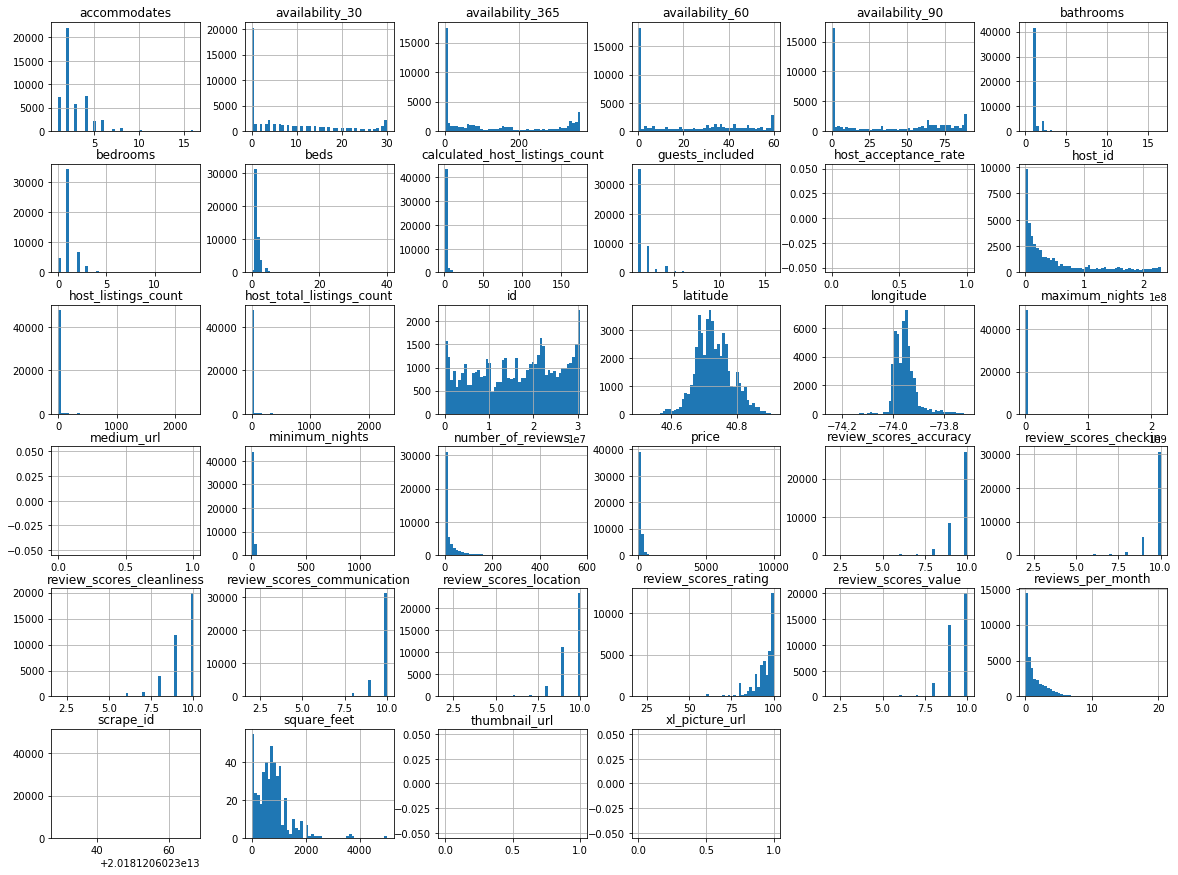

In [6]:
import matplotlib.pyplot as plt
Airbnb_data.hist(bins=50, figsize=(20,15))
plt.show()

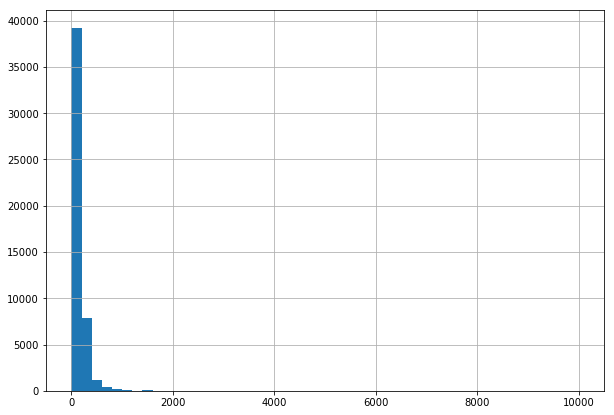

In [7]:
# view a hist of the prices
import matplotlib.pyplot as plt
Airbnb_data.price.hist(bins=50, figsize=(10,7))
plt.show()

In [8]:
# remove all listings where the price is less then 500
Airbnb_data = Airbnb_data[Airbnb_data.price < 500]

In [9]:
Airbnb_data.price.describe()

count    47813.000000
mean       131.115324
std         85.134756
min          0.000000
25%         69.000000
50%        105.000000
75%        174.000000
max        499.000000
Name: price, dtype: float64

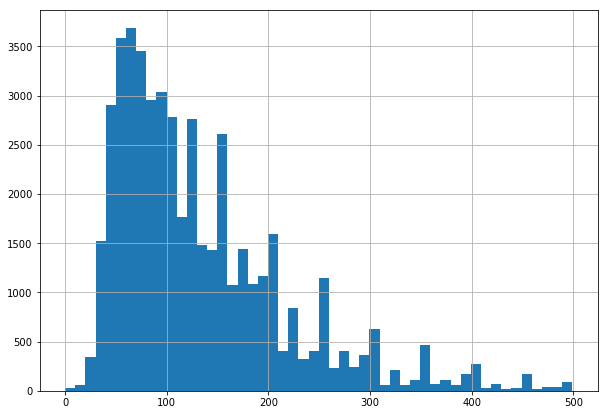

In [10]:
import matplotlib.pyplot as plt
Airbnb_data.price.hist(bins=50, figsize=(10,7))
plt.show()

In [11]:
# how many listings have a price of zero
len(Airbnb_data.loc[Airbnb_data['price'] == 0])

25

In [12]:
# if the price is less then 10 revome the listing
Airbnb_data = Airbnb_data[Airbnb_data.price > 10]

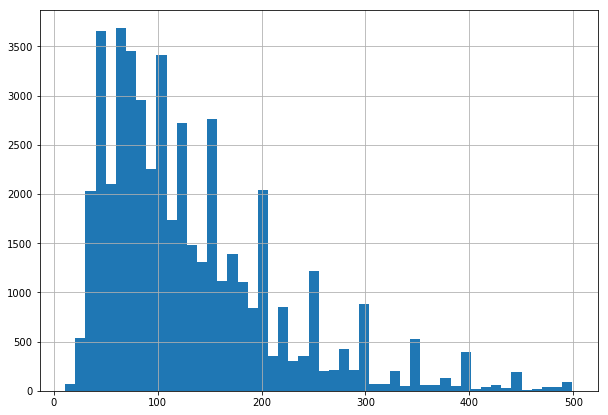

In [13]:
import matplotlib.pyplot as plt
Airbnb_data.price.hist(bins=50, figsize=(10,7))
plt.show()

- also removing listing that are not active 

In [14]:
Airbnb_data.reviews_per_month.describe()

count    37994.000000
mean         1.439136
std          1.682883
min          0.010000
25%          0.220000
50%          0.780000
75%          2.160000
max         20.330000
Name: reviews_per_month, dtype: float64

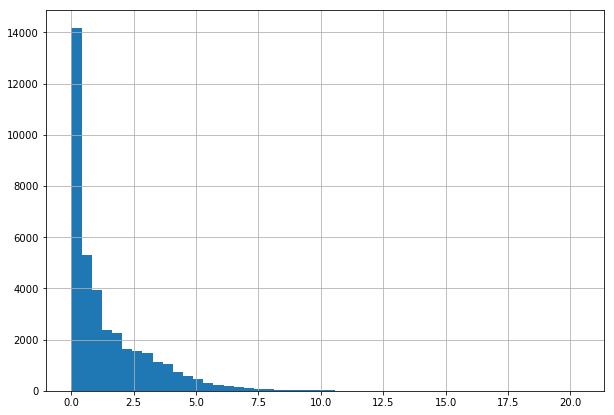

In [15]:
import matplotlib.pyplot as plt
Airbnb_data.reviews_per_month.hist(bins=50, figsize=(10,7))
plt.show()

In [16]:
# if there is not a lot of activity the listing will be droped
Airbnb_data = Airbnb_data[Airbnb_data.reviews_per_month > .12]

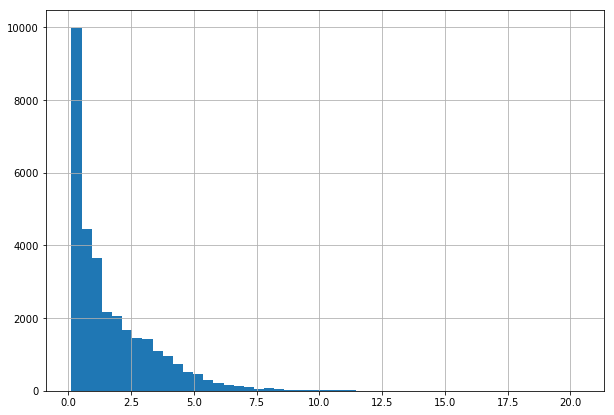

In [17]:
import matplotlib.pyplot as plt
Airbnb_data.reviews_per_month.hist(bins=50, figsize=(10,7))
plt.show()

- a heat map of the listings in NY 
    - the color represents the price 
    - the size of the circle represents the number of reviews

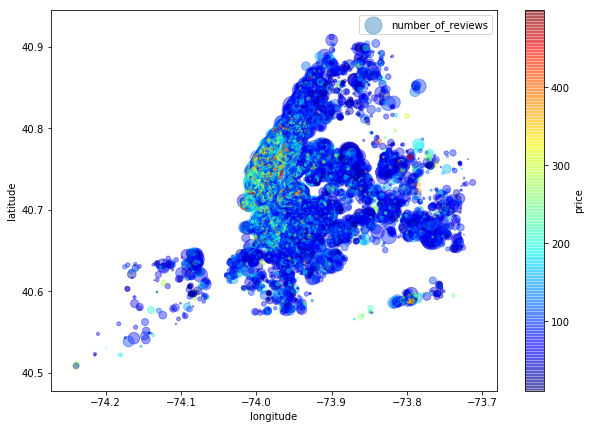

In [18]:
Airbnb_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=Airbnb_data["number_of_reviews"], label="number_of_reviews", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [19]:
Airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31874 entries, 0 to 49037
Data columns (total 96 columns):
id                                  31874 non-null int64
listing_url                         31874 non-null object
scrape_id                           31874 non-null int64
last_scraped                        31874 non-null object
name                                31872 non-null object
summary                             30724 non-null object
space                               24499 non-null object
description                         31624 non-null object
experiences_offered                 31874 non-null object
neighborhood_overview               21729 non-null object
notes                               15179 non-null object
transit                             22622 non-null object
access                              21080 non-null object
interaction                         20560 non-null object
house_rules                         21131 non-null object
thumbnail_url          

In [20]:
# see how many pictures there are
len(Airbnb_data['picture_url'])

31874

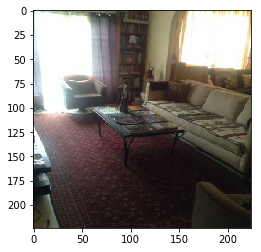

In [21]:
# view one of the images
from PIL import Image
import requests
from io import BytesIO

IMAGE_SIZE = [224,224]

response = requests.get(Airbnb_data['picture_url'][4])
img = Image.open(BytesIO(response.content)).resize(IMAGE_SIZE)
plt.imshow(img)

In [22]:
Airbnb_data.price[4]

89.0

## preparing the data fro trainig

In [23]:
# mix the data
Airbnb_data = Airbnb_data.sample(frac=1)

In [24]:
# gets a list of the images as well as the prices
def get_img():
  img_list = []
  price_list = []
  data_dict=()
  for i in range(500):#len(Airbnb_data['price'])):
    try:
      if i % 100 == 0:
        # gets 6,000 images
        print(int((i/500)*100),'% done')#len(data['price']))*100)
      response = requests.get(Airbnb_data['picture_url'][i])
      img = Image.open(BytesIO(response.content)).resize([224,224])

      img = np.array(img) / 255.0 # makes imputs [0,1]
      img_list.append(img)
      price_list.append(Airbnb_data.price[i])
    except (KeyError or OSError):
      pass
  return img_list, price_list

In [25]:
X, y = get_img()


0 % done
20 % done
40 % done
60 % done
80 % done


In [31]:
len(test_y)

60

In [30]:
# split up the training set and test set
train_X = np.asarray(X[:350])
train_y = y[:350]
test_X = np.asarray(X[350:])
test_y = y[350:]

In [28]:
!pip install Keras

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### custom CNN
- here is the model i made

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, AveragePooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=3,strides=2, activation='relu',padding='SAME', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='VALID'))
model.add(Conv2D(64, kernel_size=3,strides=1, activation='relu',padding='SAME'))
model.add(AveragePooling2D(pool_size=(3,3),strides=1,padding='VALID'))
model.add(Conv2D(128, kernel_size=3,strides=2, activation='relu',padding='SAME'))
model.add(Dropout(.5))
model.add(Conv2D(64, kernel_size=3,strides=1, activation='relu',padding='SAME'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(.25))
model.add(Dense(31,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

Using TensorFlow backend.


In [30]:
# trains the model
history = model.fit(train_X, train_y, epochs=5,validation_split = 0.2,batch_size=50)


Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 [==============================] - 305s 95ms/step - loss: 10111.3994 - mean_squared_error: 10111.3994 - mean_absolute_error: 74.6828 - val_loss: 9929.9121 - val_mean_squared_error: 9929.9121 - val_mean_absolute_error: 67.5746
Epoch 2/5
3200/3200 [==============================] - 203s 64ms/step - loss: 7403.4786 - mean_squared_error: 7403.4786 - mean_absolute_error: 63.8803 - val_loss: 7901.7018 - val_mean_squared_error: 7901.7018 - val_mean_absolute_error: 61.3877
Epoch 3/5
3200/3200 [==============================] - 205s 64ms/step - loss: 7651.9754 - mean_squared_error: 7651.9754 - mean_absolute_error: 65.3754 - val_loss: 8233.9847 - val_mean_squared_error: 8233.9847 - val_mean_absolute_error: 61.9333
Epoch 4/5
3200/3200 [==============================] - 205s 64ms/step - loss: 6995.6130 - mean_squared_error: 6995.6130 - mean_absolute_error: 62.1130 - val_loss: 9873.5381 - val_mean_squared_error: 9873.5381 - val_mean

In [31]:
pred = model.predict(test_X)
print(np.sqrt(np.mean((pred - test_y)**2)))

77.54728732897499


### InceptionV3 Model
    1. train the new layers
    

In [40]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = Dropout(.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='selu')(x)
x = Dropout(.5)(x)
# and output layer
predictions = Dense(1)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='mse',metrics=['mse','mae'])

# train the model on the new data for a few epochs
model.fit(train_X[:200],train_y[:200],steps_per_epoch=10, epochs=3,validation_split = 0.2,validation_steps=10)



Train on 160 samples, validate on 40 samples
Epoch 1/3
10/10 [==============================] - 378s 38s/step - loss: 7508.2644 - mean_squared_error: 7508.2644 - mean_absolute_error: 62.9960 - val_loss: 15443.9893 - val_mean_squared_error: 15443.9893 - val_mean_absolute_error: 111.8166
Epoch 2/3
10/10 [==============================] - 366s 37s/step - loss: 4896.6964 - mean_squared_error: 4896.6964 - mean_absolute_error: 51.9902 - val_loss: 15227.5879 - val_mean_squared_error: 15227.5879 - val_mean_absolute_error: 110.6499
Epoch 3/3
10/10 [==============================] - 357s 36s/step - loss: 4317.6456 - mean_squared_error: 4317.6456 - mean_absolute_error: 48.8022 - val_loss: 15497.4482 - val_mean_squared_error: 15497.4482 - val_mean_absolute_error: 111.3496


In [41]:
pred = model.predict(test_X)
print(np.sqrt(np.mean((pred - test_y)**2)))

122.33064777473837


    2. train some of the inception V3 layers

In [43]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.00001, momentum=0.99), loss='mse',metrics=['mse','mae'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_X[:200],train_y[:200],steps_per_epoch=10, epochs=3,validation_split = 0.2,validation_steps=10)

0 input_6
1 conv2d_471
2 batch_normalization_471
3 activation_471
4 conv2d_472
5 batch_normalization_472
6 activation_472
7 conv2d_473
8 batch_normalization_473
9 activation_473
10 max_pooling2d_21
11 conv2d_474
12 batch_normalization_474
13 activation_474
14 conv2d_475
15 batch_normalization_475
16 activation_475
17 max_pooling2d_22
18 conv2d_479
19 batch_normalization_479
20 activation_479
21 conv2d_477
22 conv2d_480
23 batch_normalization_477
24 batch_normalization_480
25 activation_477
26 activation_480
27 average_pooling2d_46
28 conv2d_476
29 conv2d_478
30 conv2d_481
31 conv2d_482
32 batch_normalization_476
33 batch_normalization_478
34 batch_normalization_481
35 batch_normalization_482
36 activation_476
37 activation_478
38 activation_481
39 activation_482
40 mixed0
41 conv2d_486
42 batch_normalization_486
43 activation_486
44 conv2d_484
45 conv2d_487
46 batch_normalization_484
47 batch_normalization_487
48 activation_484
49 activation_487
50 average_pooling2d_47
51 conv2d_483
52

In [44]:
pred = model.predict(test_X)
print(np.sqrt(np.mean((pred - test_y)**2)))

96.00813582349984


**side note**: the InceptionV3 model was only trained on a training set of 200 and only 15 epoches, the algorithm would probably do better if the training set size was increased as well as the number of Epoches. i would probably do it my self if i had more patients 

below is just an example of how the model did

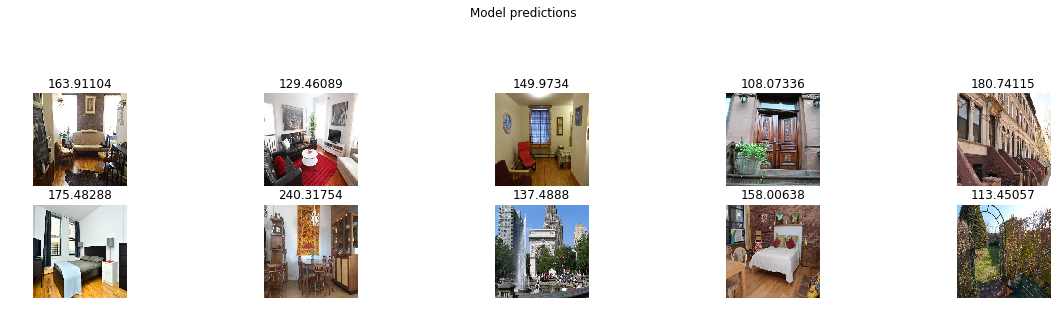

In [51]:
plt.figure(figsize=(20,12))
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(test_X[n])
  plt.title(pred[n][0])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

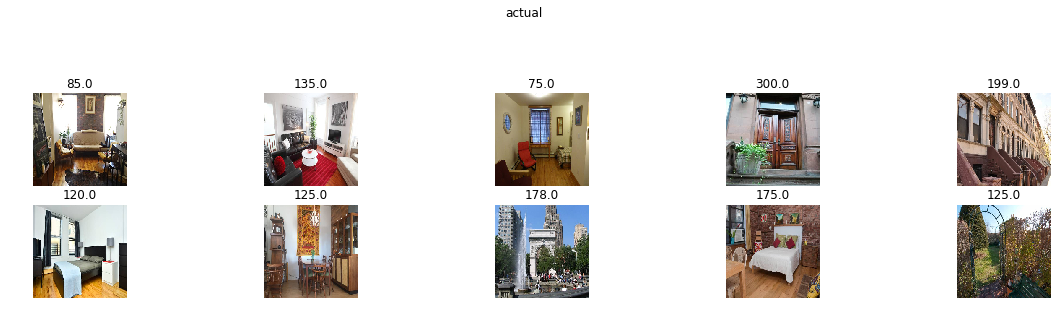

In [56]:
plt.figure(figsize=(20,12))
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(test_X[n])
  plt.title(test_y[n])
  plt.axis('off')
_ = plt.suptitle("actual")

**conclution**: i would not souly relly on this model to prdict the price of an Aribnb listing however, it coulb be usefull if you add other factors to the model like location, or rooms,..., another use case for this model could be desiding what picture to put first for a listing to maximize the listing price 